In [ ]:
import os

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
store_sales = pd.read_csv("train_new.csv")
store_sales.head(10)


,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10
5,1/6/2013,1,1,12
6,1/7/2013,1,1,10
7,1/8/2013,1,1,9
8,1/9/2013,1,1,12
9,1/10/2013,1,1,9


check for null values in the dataset

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    208 non-null    object
 1   store   208 non-null    int64 
 2   item    208 non-null    int64 
 3   sales   208 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.6+ KB


dropping store and item columns

In [ ]:
store_sales=store_sales.drop(['store', 'item'], axis=1)

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    208 non-null    object
 1   sales   208 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


converting date from object datatype to datetime datatype

In [ ]:
store_sales['date']=pd.to_datetime(store_sales['date'])

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    208 non-null    datetime64[ns]
 1   sales   208 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.4 KB


converting date to month period and then sum the number of items in each month

In [ ]:
store_sales['date']= store_sales['date'].dt.to_period()

In [ ]:
monthly_sales = store_sales.groupby('date').sum().reset_index()

convert the resulting date column to timestamp datatype

In [ ]:
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()

In [ ]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10
5,2013-01-06,12
6,2013-01-07,10
7,2013-01-08,9
8,2013-01-09,12
9,2013-01-10,9


visualization

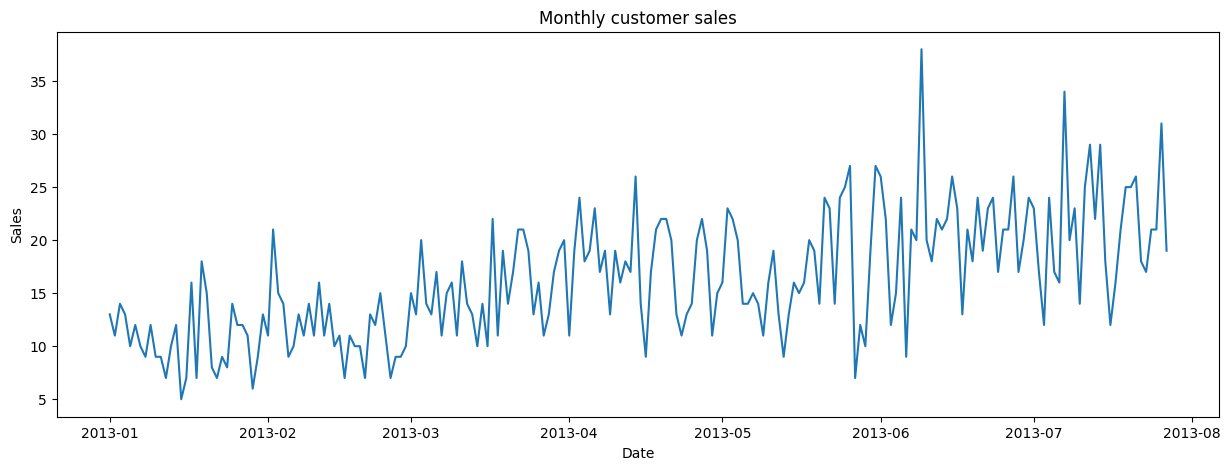

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly customer sales")
plt.show()

call the difference on the sales columns to make the sale data stationary

In [ ]:
monthly_sales['sales_diff']= monthly_sales['sales'].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-01-02,11,-2.0
2,2013-01-03,14,3.0
3,2013-01-04,13,-1.0
4,2013-01-05,10,-3.0
5,2013-01-06,12,2.0
6,2013-01-07,10,-2.0
7,2013-01-08,9,-1.0
8,2013-01-09,12,3.0
9,2013-01-10,9,-3.0
10,2013-01-11,9,0.0


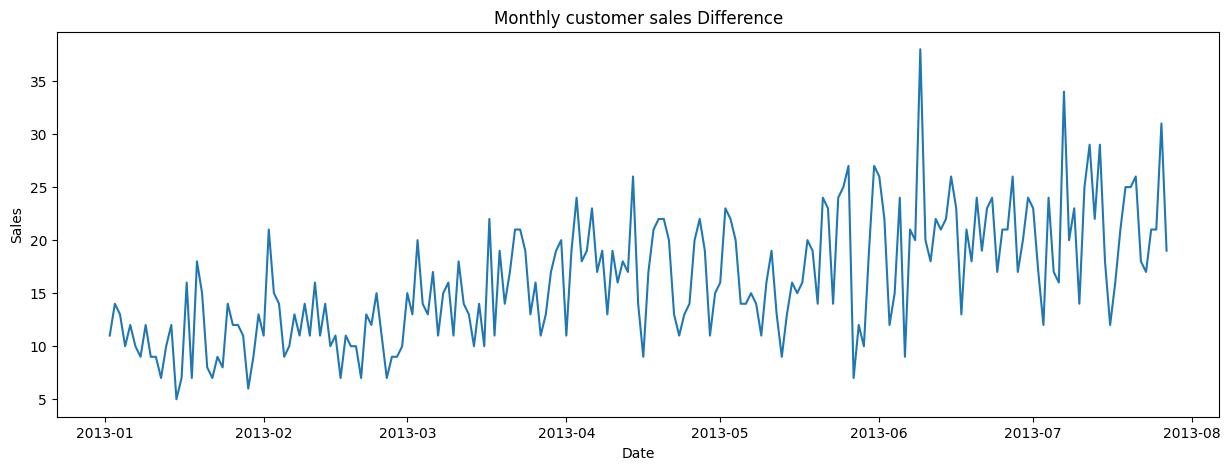

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly customer sales Difference")
plt.show()


Dropping off sales and date

In [ ]:
supervised_data=monthly_sales.drop(['date', 'sales'], axis=1)

preparing the supervised data

In [ ]:
for i in range(1,13):
 col_name= 'month_' + str(i)
 supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2.0,3.0,-2.0,0.0,-3.0,3.0,-1.0,-2.0,2.0,-3.0,-1.0,3.0,-2.0
1,-7.0,2.0,3.0,-2.0,0.0,-3.0,3.0,-1.0,-2.0,2.0,-3.0,-1.0,3.0
2,2.0,-7.0,2.0,3.0,-2.0,0.0,-3.0,3.0,-1.0,-2.0,2.0,-3.0,-1.0
3,9.0,2.0,-7.0,2.0,3.0,-2.0,0.0,-3.0,3.0,-1.0,-2.0,2.0,-3.0
4,-9.0,9.0,2.0,-7.0,2.0,3.0,-2.0,0.0,-3.0,3.0,-1.0,-2.0,2.0
5,11.0,-9.0,9.0,2.0,-7.0,2.0,3.0,-2.0,0.0,-3.0,3.0,-1.0,-2.0
6,-3.0,11.0,-9.0,9.0,2.0,-7.0,2.0,3.0,-2.0,0.0,-3.0,3.0,-1.0
7,-7.0,-3.0,11.0,-9.0,9.0,2.0,-7.0,2.0,3.0,-2.0,0.0,-3.0,3.0
8,-1.0,-7.0,-3.0,11.0,-9.0,9.0,2.0,-7.0,2.0,3.0,-2.0,0.0,-3.0
9,2.0,-1.0,-7.0,-3.0,11.0,-9.0,9.0,2.0,-7.0,2.0,3.0,-2.0,0.0


split the data into train and test

In [ ]:
train_data = supervised_data[:-12]

In [ ]:
test_data = supervised_data[-12:]
print("train data shape:",train_data.shape)
print(" test data shape:", test_data.shape)

train data shape: (183, 13)
 test data shape: (12, 13)


In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
x_train, y_train =train_data[:,1:],train_data[:,0:1]
x_test, y_test =test_data[:,1:],test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape:",x_train.shape)
print("y_train shape:",y_train.shape)
print("x_test shape:",x_test.shape)
print("x_test shape:",y_test.shape)

x_train shape: (183, 12)
y_train shape: (183,)
x_test shape: (12, 12)
x_test shape: (12,)


so far we have done data preprocessing. in the last step of data preprocessing we are going to make prediction data frame in order to merge the predicted sales price of all the trained algos.

make prediction dta frame  to merge the predicted sales prices of all trained algs

In [ ]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[18, 12, 16, 21, 25, 25, 26, 18, 17, 21, 21, 31, 19]


to create the linear regression model,  and predicted output

In [ ]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [ ]:
lr_pre=lr_pre.reshape(-1,1)
# this is a set matrix - containjs the input feature of the test data andalso the predicted output
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [ ]:
result_list=[]
for index in range(0, len(lr_pre_test_set)):
 result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [ ]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score = (predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linear Regression MSE:",lr_mse)
print("Linear Regression MAE:", lr_mae)
print("Linear Regression R2:", lr_r2 )
#print(predict_df)

Linear Regression MSE: 4.288534706601206
Linear Regression MAE: 3.391228466380163
Linear Regression R2: (0     20.390878
1     18.927804
2     22.293197
3     25.469494
4     23.090804
5     23.017428
6     22.802182
7     17.319805
8     18.828771
9     23.080116
10    22.594760
11    23.943029
Name: Linear Prediction, dtype: float64, 196    12
197    16
198    21
199    25
200    25
201    26
202    18
203    17
204    21
205    21
206    31
207    19
Name: sales, dtype: int64)


visualization of the prediction against the actual sales

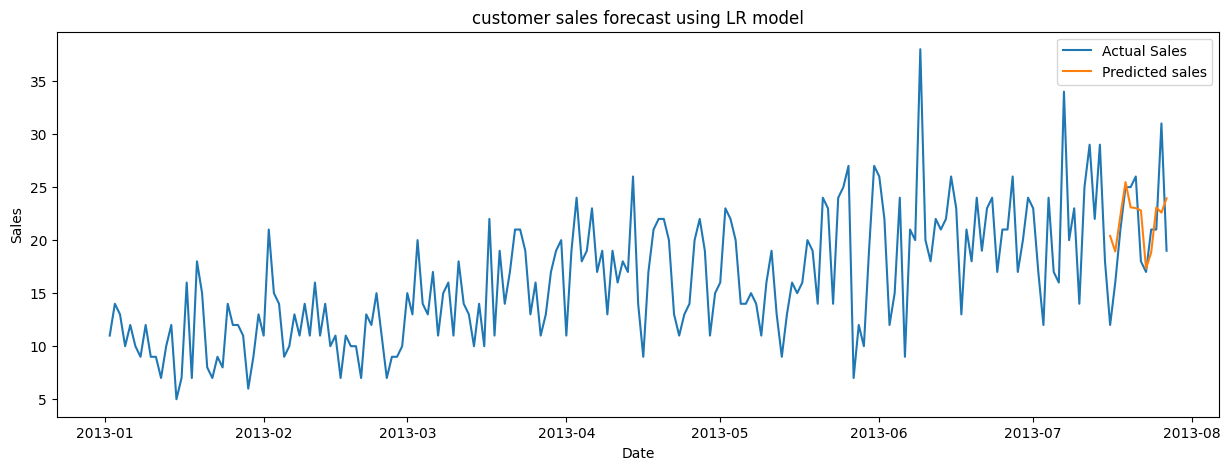

In [ ]:
plt.figure(figsize=(15,5))
# actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# predicted sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("customer sales forecast using LR model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted sales'])
plt.show()
